In [193]:
!pip install pca

In [194]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)
# Load dataset

data_path = "../datasets/wine_development(in).csv"
df = pd.read_csv(data_path)

df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,wine_id
0,5.8,0.31,0.32,4.5,0.024,28.0,94.0,0.98906,3.25,0.52,13.7,7,white,1198
1,6.3,0.13,0.42,1.1,0.043,63.0,146.0,0.99066,3.13,0.72,11.2,7,white,3409
2,8.2,0.30,0.44,12.4,0.043,52.0,154.0,0.99452,3.04,0.33,12.0,6,white,4789
3,9.4,0.17,0.55,1.6,0.049,14.0,94.0,0.99490,3.02,0.61,10.3,6,white,3054
4,5.3,0.30,0.16,4.2,0.029,37.0,100.0,0.99050,3.30,0.36,11.8,8,white,2812


# 1. Data Preperation

## 1.1 Check for outliers

In [195]:


# Number of missing values per column
missing_values = df.isna().sum()

missing_values


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
color                   0
wine_id                 0
dtype: int64

In [196]:

numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns

numeric_columns


Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'wine_id'],
      dtype='object')

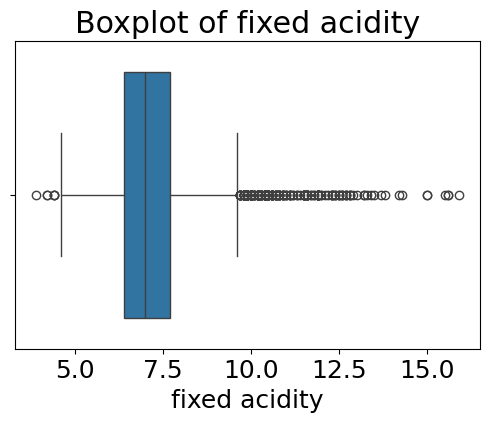

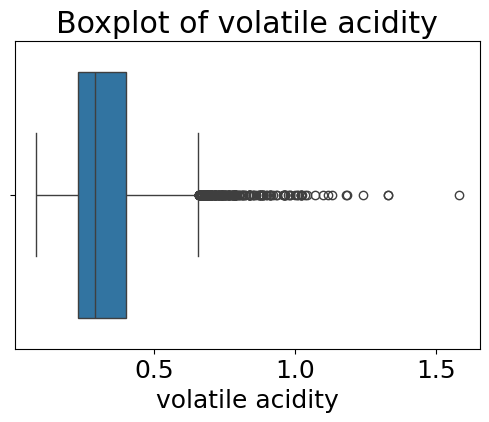

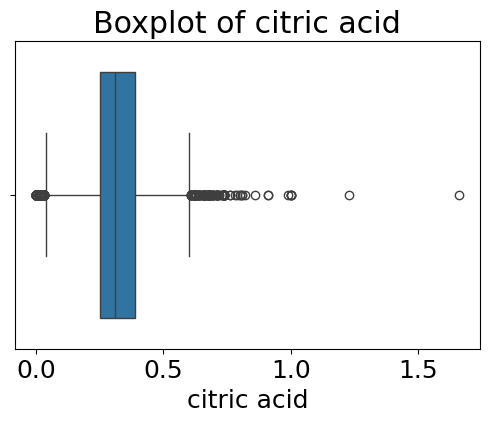

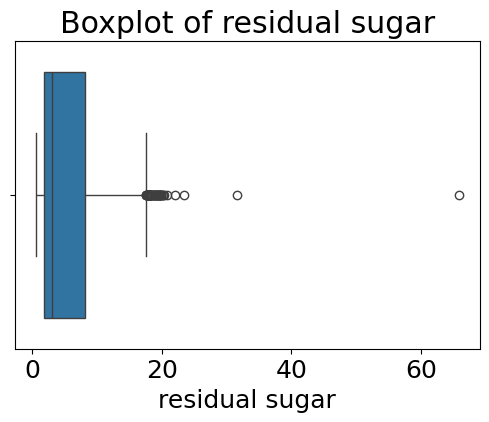

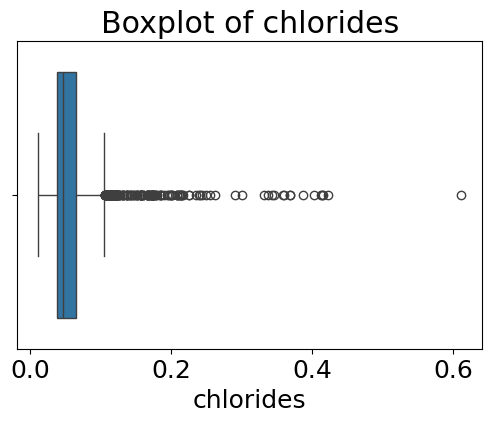

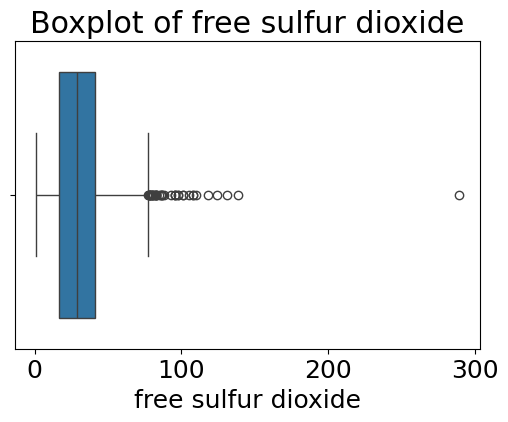

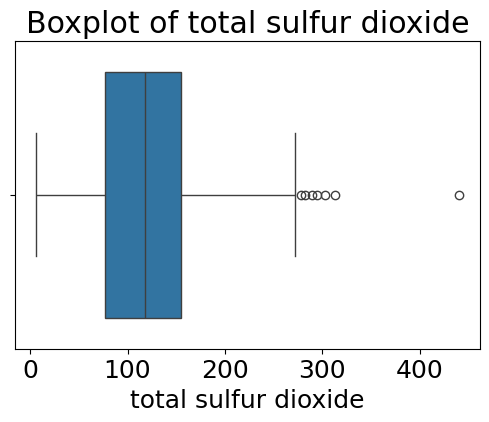

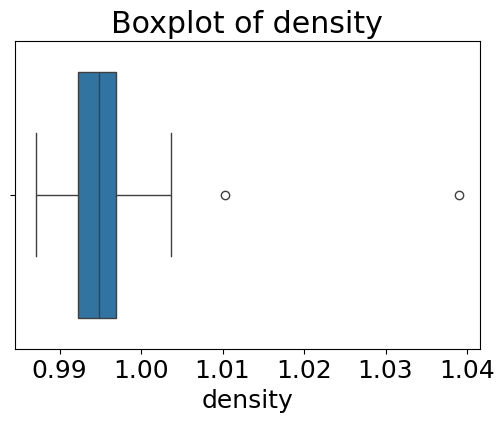

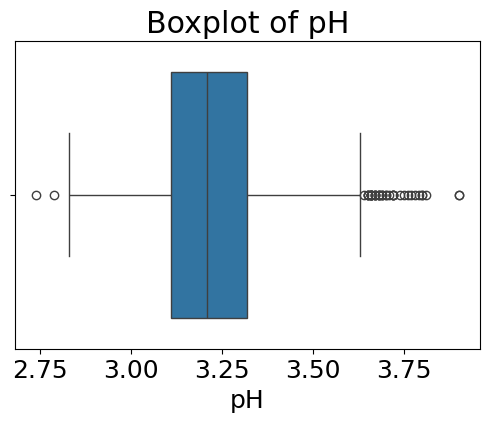

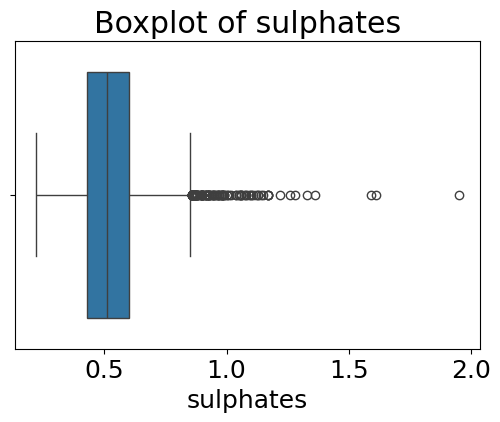

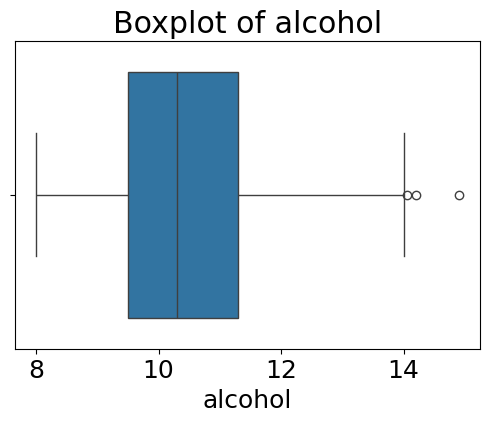

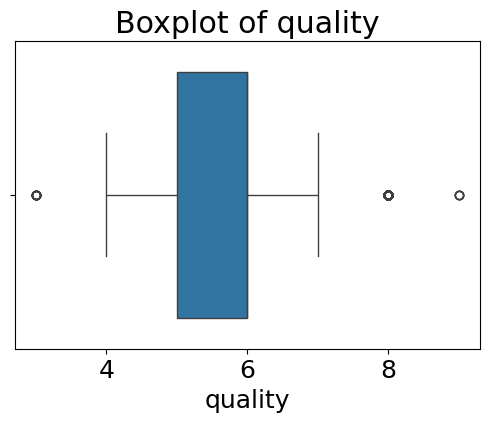

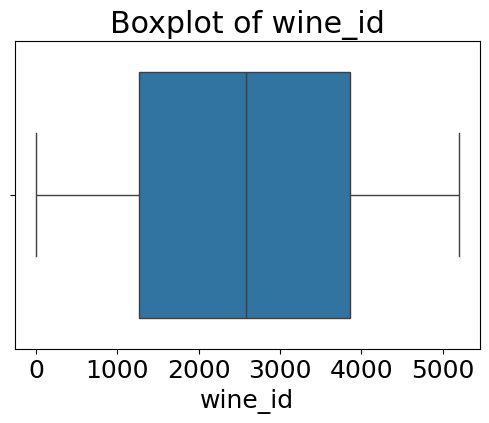

In [197]:

# Boxplots for each numeric variable

for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


## 1.2 Check for balance/imbalance of class labels

In [198]:

target = "color"


In [199]:

class_counts = df[target].value_counts()
class_counts


color
white    3134
red      1023
Name: count, dtype: int64

In [200]:

class_percentages = df[target].value_counts(normalize=True) * 100
class_percentages


color
white    75.390907
red      24.609093
Name: proportion, dtype: float64

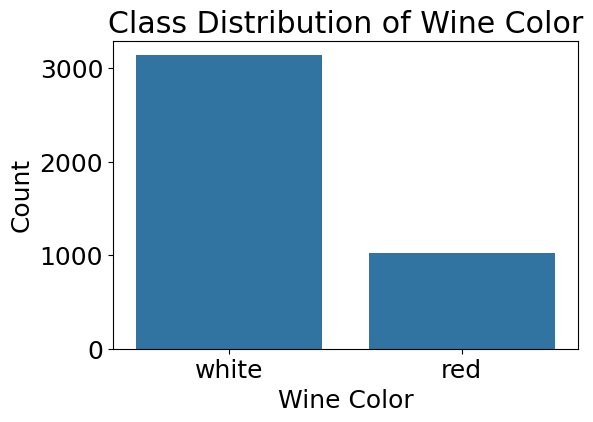

In [201]:

plt.figure(figsize=(6, 4))
sns.countplot(x=target, data=df)
plt.title("Class Distribution of Wine Color")
plt.xlabel("Wine Color")
plt.ylabel("Count")
plt.show()


## 1.3 Split data + Scale data

In [202]:

# Split into features (X) and target (y)

target = "color"

X = df.drop(columns=[target])
y = df[target]

# Train/Test split (stratified)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Keep class proportions
)


# Feature scaling (fit on train, transform both)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)   # Fit ONLY on train
X_test_scaled = scaler.transform(X_test)         # Transform test with same scaler

# Quick check: shapes
X_train_scaled.shape, X_test_scaled.shape


((3325, 13), (832, 13))

## 1.4 Use stratified splits to preserver class proportions

In [203]:

# Check class proportions in full / train / test


# Full dataset proportions
full_props = y.value_counts(normalize=True)

# Train set proportions
train_props = y_train.value_counts(normalize=True)

# Test set proportions
test_props = y_test.value_counts(normalize=True)

# Combine into one table
class_distribution_check = pd.DataFrame({
    "full": full_props,
    "train": train_props,
    "test": test_props
}).fillna(0)

# Show as percentages
(class_distribution_check * 100).round(2)


,full,train,test
color,,,
white,75.39,75.4,75.36
red,24.61,24.6,24.64


## SVM with RBF kernel

In [204]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## Loop Over Different gamma Values to find better

In [205]:
gamma_values = [0.01, 0.1]
C_values = [0.1, 1]
for gamma in gamma_values:
    for C in C_values:
        svm_rbf = SVC(
            kernel="rbf",
            C=C,
            gamma=gamma,
            random_state=42
        )
    
    svm_rbf.fit(X_train_scaled, y_train)
    y_test_pred = svm_rbf.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_test_pred)
    print(f"gamma={gamma}, Test Accuracy: {acc:.4f}")
    print(f"C={C} → Test Accuracy: {acc:.4f}")

gamma=0.01, Test Accuracy: 0.9964
C=1 → Test Accuracy: 0.9964
gamma=0.1, Test Accuracy: 0.9964
C=1 → Test Accuracy: 0.9964


In [206]:
svm_rbf = SVC(
    kernel="rbf",
    C=C,
    gamma=gamma,
    random_state=42
)

svm_rbf.fit(X_train_scaled, y_train)


,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",0.1
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [207]:
print(C)
print (gamma)

1
0.1


In [208]:
y_train_pred = svm_rbf.predict(X_train_scaled)
y_test_pred = svm_rbf.predict(X_test_scaled)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

Train Accuracy: 0.9966917293233083
Test Accuracy: 0.9963942307692307

Classification Report (Test Set):
              precision    recall  f1-score   support

         red       1.00      0.99      0.99       205
       white       1.00      1.00      1.00       627

    accuracy                           1.00       832
   macro avg       1.00      0.99      1.00       832
weighted avg       1.00      1.00      1.00       832



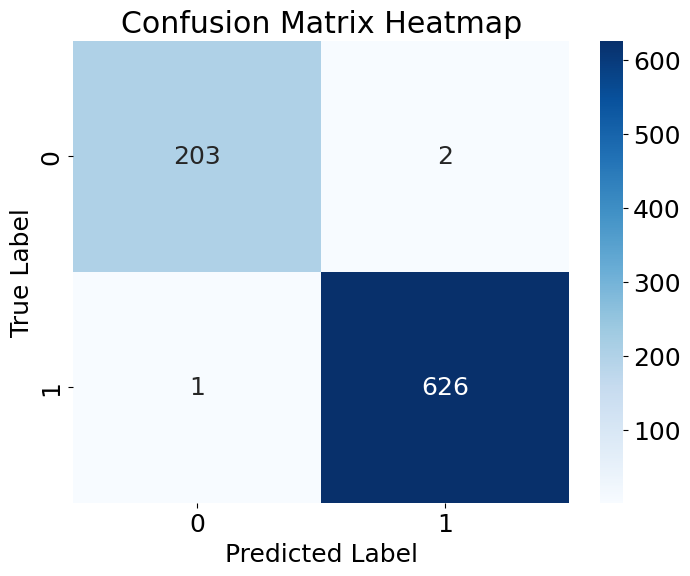

In [209]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

## perform PCA

[17-01-2026 01:13:12] [pca.pca] [INFO] Row labels are auto-completed.
[17-01-2026 01:13:12] [pca.pca] [INFO] The PCA reduction is performed on 13 variables (columns) of the input dataframe.
[17-01-2026 01:13:12] [pca.pca] [INFO] Fit using PCA.
[17-01-2026 01:13:12] [pca.pca] [INFO] Compute loadings and PCs.
[17-01-2026 01:13:12] [pca.pca] [INFO] Compute explained variance.
[17-01-2026 01:13:12] [pca.pca] [INFO] Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[17-01-2026 01:13:12] [pca.pca] [INFO] Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[17-01-2026 01:13:12] [pca.pca] [INFO] Outlier detection using SPE/DmodX with n_std=[3]
[17-01-2026 01:13:12] [pca.pca] [WARNING] Parameter <label> is deprecated and will not be supported in future version.
[17-01-2026 01:13:12] [pca.pca] [INFO] Plot PC1 vs PC2 with loadings.
[17-01-2026 01:13:12] [scatterd.scatterd] [INFO] Create scatterplot


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': 'The top 2 Principal Component(s) explains [43.71%] of the variance.'}, xlabel='PC1 (23.2% expl.var)', ylabel='PC2 (20.4% expl.var)'>)

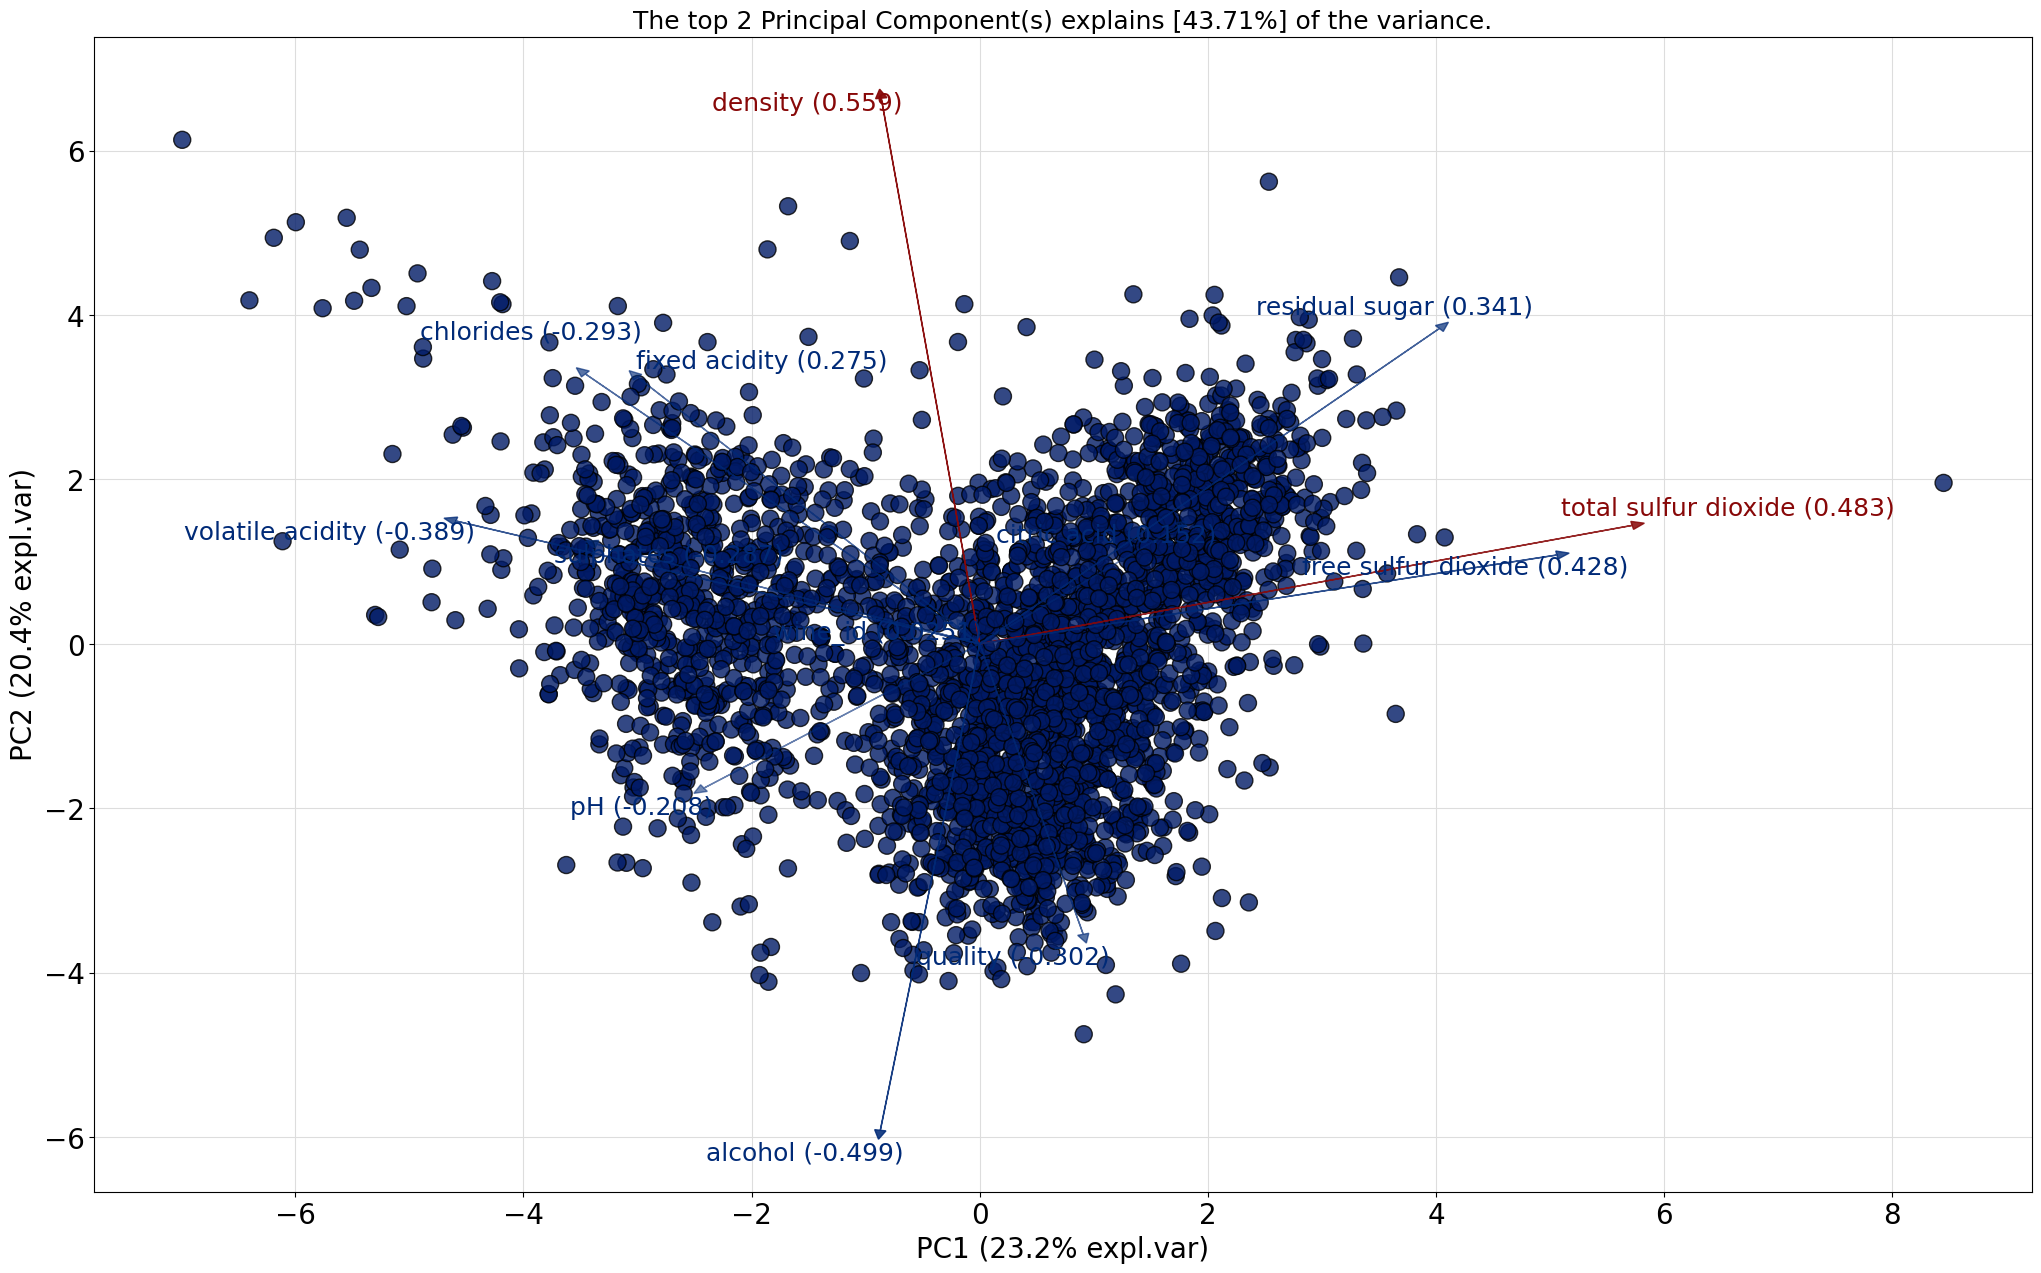

In [210]:
from pca import pca
model = pca(n_components=2) 
labels = X.columns
results = model.fit_transform(X_train_scaled, col_labels=labels)
model.biplot(label=True, legend=True)

In [211]:
model.results['topfeat']

,PC,feature,loading,type
0,PC1,total sulfur dioxide,0.482845,best
1,PC2,density,0.559098,best
2,PC2,fixed acidity,0.275432,weak
3,PC1,volatile acidity,-0.389203,weak
4,PC1,citric acid,0.151580,weak
5,PC1,residual sugar,0.340506,weak
6,PC1,chlorides,-0.293088,weak
7,PC1,free sulfur dioxide,0.428243,weak
8,PC1,pH,-0.207689,weak
9,PC1,sulphates,-0.286673,weak


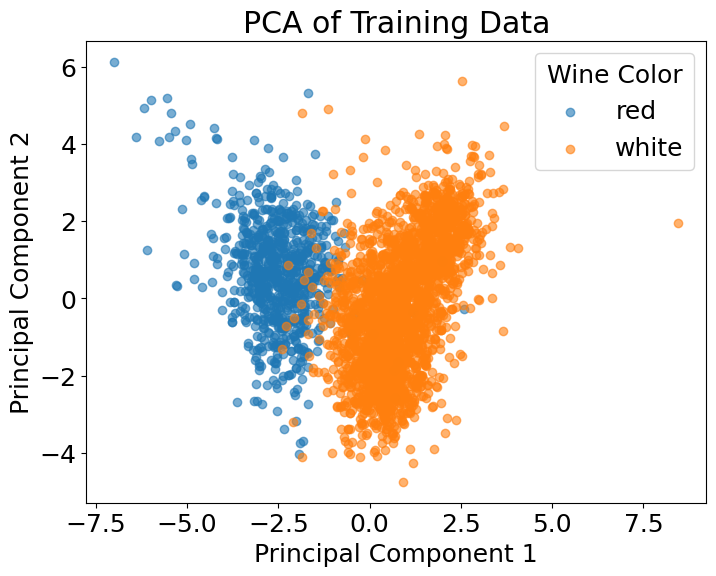

In [212]:
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
plt.figure(figsize=(8, 6))
for label, color in zip(np.unique(y_train), ['red', 'blue']):
    plt.scatter(
        X_train_pca[y_train == label, 0],
        X_train_pca[y_train == label, 1],
        label=label,
        alpha=0.6
    )
plt.title("PCA of Training Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Wine Color")
plt.show()

### UNSEEN DATA EVALUATION

In [213]:
X_holdout = pd.read_csv("..\\datasets\\wine_holdout_X(in).csv")
y_holdout = pd.read_csv("..\\datasets\\wine_holdout_y(in).csv")

In [214]:
y_holdout = y_holdout["color"]

In [215]:
X_holdout_scaled = scaler.transform(X_holdout)

In [216]:
y_holdout_pred = svm_rbf.predict(X_holdout_scaled)

In [217]:
print("Holdout Accuracy:", accuracy_score(y_holdout, y_holdout_pred))

print("\nHoldout Classification Report:")
print(classification_report(y_holdout, y_holdout_pred))


Holdout Accuracy: 0.9951923076923077

Holdout Classification Report:
              precision    recall  f1-score   support

         red       1.00      0.98      0.99       256
       white       0.99      1.00      1.00       784

    accuracy                           1.00      1040
   macro avg       1.00      0.99      0.99      1040
weighted avg       1.00      1.00      1.00      1040



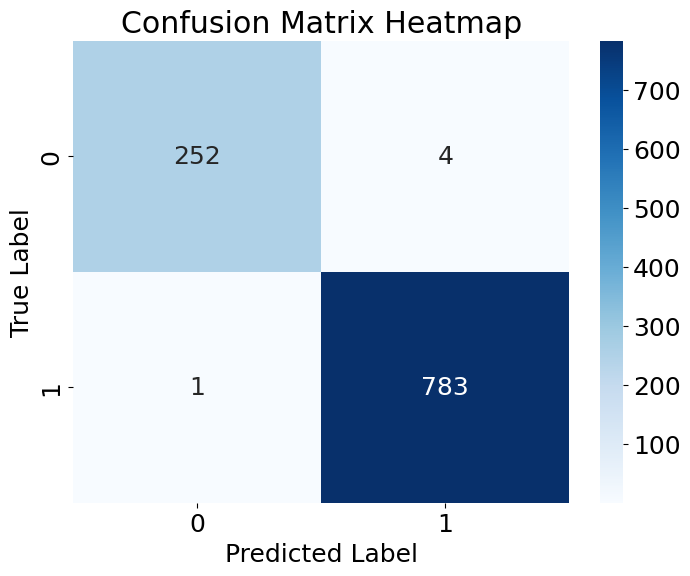

In [218]:
cm = confusion_matrix(y_holdout, y_holdout_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [219]:
df_bonus = df.copy()

df_bonus["excellent"] = (df_bonus["quality"] >= 6).astype(int)


In [220]:
X_bonus = df_bonus.drop(columns=["excellent", "quality", "color", "wine_id"])
y_bonus = df_bonus["excellent"]

In [221]:
y_bonus.value_counts(normalize=True)


excellent
1    0.635073
0    0.364927
Name: proportion, dtype: float64

In [222]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bonus,
    y_bonus,
    test_size=0.2,
    random_state=42,
    stratify=y_bonus
)


In [223]:

Xb_train_scaled = scaler.fit_transform(Xb_train)
Xb_test_scaled = scaler.transform(Xb_test)

In [224]:
svm_quality = svm_rbf

svm_quality.fit(Xb_train_scaled, yb_train)


,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",0.1
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [225]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

yb_pred = svm_quality.predict(Xb_test_scaled)

print("Test Accuracy:", accuracy_score(yb_test, yb_pred))
print("\nClassification Report:")
print(classification_report(yb_test, yb_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(yb_test, yb_pred))


Test Accuracy: 0.7848557692307693

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.64      0.69       304
           1       0.81      0.87      0.84       528

    accuracy                           0.78       832
   macro avg       0.77      0.76      0.76       832
weighted avg       0.78      0.78      0.78       832


Confusion Matrix:
[[196 108]
 [ 71 457]]
